# Problem statement

*Context*: Twitter is a microblogging and social networking service on which users post and interact with messages known as "tweets". Every second, on average, around 6,000 tweets are tweeted on Twitter, corresponding to over 350,000 tweets sent per minute, 500 million tweets per day.
Twitter wants to automatically tag and analyze tweets for better understanding of the trends and topics without being dependent on the hashtags that the users use. Many users do not use hashtags or sometimes use wrong or mis-spelled tags, so they want to completely remove this problem and create a system of recognizing important content of the tweets.

*Objective*: You need to train a model that will be able to identify the various named entities.


## Downloading data

In [ ]:
!gdown 14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
!gdown 1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_

Downloading...
From: https://drive.google.com/uc?id=14_VHffl1qBUEnZ1IWFHnh6B9M5_A-Wf8
To: /content/wnut 16.txt.conll
100% 403k/403k [00:00<00:00, 118MB/s]
Downloading...
From: https://drive.google.com/uc?id=1cnrGjppPOU_NtHNpGu0RJGg1CUNNsse_
To: /content/wnut 16test.txt.conll
100% 635k/635k [00:00<00:00, 132MB/s]


## Installing libraries

In [ ]:
%pip install datasets transformers
%pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import tensorflow as tf

## Loading data from the files

In [ ]:
def load_data(filename: str):
  # Conll file is stored as (token, tag) pairs, one per line
  # Extracting data from conll files
  with open(filename, 'r') as file:
    lines = [line[:-1].split() for line in file] # Skipping last line as it will be a blank space
  samples, start = [], 0
  for end, parts in enumerate(lines):
      if not parts:
          sample = [(token, tag)
                      for token, tag in lines[start:end]]
          samples.append(sample)
          start = end + 1
  if start < end:
    samples.append(lines[start:end])
  return samples

train_samples = load_data('wnut 16.txt.conll')
test_samples = load_data('wnut 16test.txt.conll')
samples = train_samples + test_samples
schema = ['_'] + sorted({tag for sentence in samples
                             for _, tag in sentence}) # '_' is used to indicate a null (blank) token.

## Structure of data

In [ ]:
train_samples[1]

[('Made', 'O'),
 ('it', 'O'),
 ('back', 'O'),
 ('home', 'O'),
 ('to', 'O'),
 ('GA', 'B-geo-loc'),
 ('.', 'O'),
 ('It', 'O'),
 ('sucks', 'O'),
 ('not', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('at', 'O'),
 ('Disney', 'B-facility'),
 ('world', 'I-facility'),
 (',', 'O'),
 ('but', 'O'),
 ('its', 'O'),
 ('good', 'O'),
 ('to', 'O'),
 ('be', 'O'),
 ('home', 'O'),
 ('.', 'O'),
 ('Time', 'O'),
 ('to', 'O'),
 ('start', 'O'),
 ('planning', 'O'),
 ('the', 'O'),
 ('next', 'O'),
 ('Disney', 'B-facility'),
 ('World', 'I-facility'),
 ('trip', 'O'),
 ('.', 'O')]

## EDA: Let's have a look at the distribution of tags on data

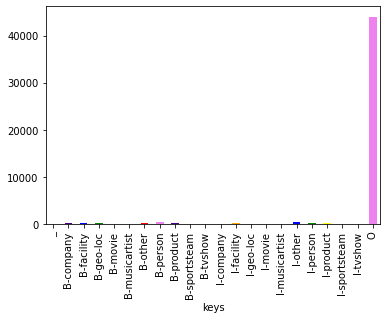

In [ ]:
import seaborn as sns
colors = ['violet', 'indigo', 'blue', 'green', 'yellow', 'orange', 'red']
counts = {}

# Calculateing the number of data points having a given label
for tag in schema:
  counts[tag] = 0
  for sample in train_samples:
    for label in sample:
      if label[1] == tag:
        counts[tag]+=1

counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

- We have too many "other" fields, which is natural as only few annotations exist per sentence
- let's remove `O` tag and see tag distribution

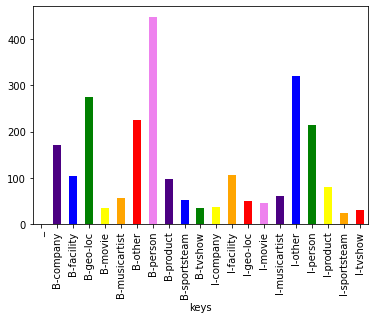

In [ ]:
counts.pop('O')
counts_df = pd.DataFrame({'keys': list(counts.keys()), 'values': list(counts.values())})
counts_df.plot.bar(x='keys', y='values', legend=False, color=colors)

## Tag information
- B-* Start token for a tag
- I-* Continuation tokens for a tag

## Available Entities
- Company
- Facility
- Geo-loc: geolocation
- Musicartist
- Person
- Product
- Sportsteam
- TV Show
- Other

### More preprocessing

- let's get vocab & sequence lengths

In [ ]:
from collections import defaultdict
all_samples = train_samples
all_samples.extend(test_samples)

word_counts = defaultdict(int) # Calculate vocab size
max_len = 0 # Calculate max length of a sentence

for sample in all_samples:
  for word in sample:
    word_counts[word[0]]+=1

  max_len = max(max_len, len(sample))

n_words = len(word_counts.items())


print("*"*30)
print("Max Length: ", max_len)
print("Vocab Size: ", n_words)

******************************
Max Length:  39
Vocab Size:  25382


## Our approach

- Train a transformer based architectures , Finetuning BERT model

# BERT Model

## Getting the  bert model

In [ ]:
from transformers import AutoConfig, TFAutoModelForTokenClassification

MODEL_NAME = 'bert-base-uncased'

# Loading the tokenizer

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # Load bert-base-uncased tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

- tokenizer adds 101 and 102 token id at the start and end of the tokens
- using[1:-1] to eliminate the extra 101, 102 that tokenizer adds
- Let us have a peak at tokenization of a training sample

In [ ]:
sample=train_samples[10] # Random tokenized sample
for token, tag in sample:
  for subtoken in tokenizer(token)['input_ids'][1:-1]:
    print(token,subtoken)

RT 19387
@Hatshepsutely 1030
@Hatshepsutely 16717
@Hatshepsutely 5369
@Hatshepsutely 4523
@Hatshepsutely 10421
@Hatshepsutely 2135
: 1024
@adamlambert 1030
@adamlambert 4205
@adamlambert 10278
@adamlambert 8296
please 3531
, 1010
oh 2821
please 3531
wear 4929
the 1996
infamous 14429
beach 3509
hat 6045
tonight 3892
during 2076
your 2115
encore 19493
( 1006
in 1999
lieu 22470
of 1997
a 1037
rasta 20710
rasta 2696
wig) 24405
wig) 1007
. 1012
&lt; 1004
&lt; 8318
&lt; 1025
3333 21211
3333 2509


### Get Datasets

In [ ]:
import numpy as np
import tqdm

def tokenize_sample(sample):
  # Expand label to all subtokens and add 'O' label to start and end tokens
  seq = [
    (subtoken, tag)
    for token, tag in sample
    for subtoken in tokenizer(token.lower())['input_ids'][1:-1]
  ]
  return [(3, 'O')] + seq + [(4, 'O')]

def preprocess(samples, tag2id):
  tokenized_samples = list((map(tokenize_sample, samples)))
  max_len = max(map(len, tokenized_samples))

  # Subtokens
  X_input_ids = np.zeros((len(samples), max_len), dtype=np.int32)

  # Masks
  X_input_masks = np.zeros((len(samples), max_len), dtype=np.int32)

  # labels
  y = np.zeros((len(samples), max_len), dtype=np.int32)

  for i, sentence in enumerate(tokenized_samples):
    for j in range(len(sentence)):
      X_input_masks[i, j] = 1
    for j, (subtoken_id, tag) in enumerate(sentence):
      X_input_ids[i, j] = subtoken_id
      y[i, j] = tag2id[tag]
  return (X_input_ids, X_input_masks), y

X_train, y_train = preprocess(train_samples, tag2id)
X_test, y_test = preprocess(test_samples, tag2id)

## Loading model

In [ ]:
config = AutoConfig.from_pretrained(MODEL_NAME, num_labels=len(schema),
                                    id2tag=id2tag, tag2id=tag2id) # Bert config

model = TFAutoModelForTokenClassification.from_pretrained(MODEL_NAME,
                                                          config=config) # Loading Bert model
model.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForTokenClassification.

Some layers of TFBertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_token_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  16918     
                                                                 
Total params: 108,908,566
Trainable params: 108,908,566
Non-trainable params: 0
_________________________________________________________________


### Fit model on training data

In [ ]:
BATCH_SIZE=32

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) # Creating optimizer

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=metric)

history = model.fit(X_train, y_train,
                  validation_split=0.2, epochs=10,
                  batch_size=BATCH_SIZE)

Epoch 1/10
157/157 [==============================] - 188s 1s/step - loss: 0.1666 - accuracy: 0.9630 - val_loss: 0.0701 - val_accuracy: 0.9845
Epoch 2/10
157/157 [==============================] - 171s 1s/step - loss: 0.0495 - accuracy: 0.9888 - val_loss: 0.0497 - val_accuracy: 0.9879
Epoch 3/10
157/157 [==============================] - 172s 1s/step - loss: 0.0311 - accuracy: 0.9919 - val_loss: 0.0432 - val_accuracy: 0.9891
Epoch 4/10
157/157 [==============================] - 172s 1s/step - loss: 0.0211 - accuracy: 0.9942 - val_loss: 0.0434 - val_accuracy: 0.9900
Epoch 5/10
157/157 [==============================] - 172s 1s/step - loss: 0.0142 - accuracy: 0.9963 - val_loss: 0.0416 - val_accuracy: 0.9911
Epoch 6/10
157/157 [==============================] - 172s 1s/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.0408 - val_accuracy: 0.9914
Epoch 7/10
157/157 [==============================] - 172s 1s/step - loss: 0.0068 - accuracy: 0.9984 - val_loss: 0.0448 - val_accuracy: 0.9913

- Lets have a side by side view of true labels and model predictions
- Arranged as an array of Tuple(token, true label, model prediction)

In [ ]:
def aggregate(sample, predictions):
  results = []
  i = 1
  for token, y_true in sample:
      nr_subtoken = len(tokenizer(token.lower())['input_ids']) - 2 # Extracting word tokens
      pred = predictions[i:i+nr_subtoken] # Extracting predictions
      i += nr_subtoken
      y_pred = schema[np.argmax(np.sum(pred, axis=0))] # Get label of prediction
      results.append((token, y_true, y_pred))
  return results

y_probs = model.predict(X_test)[0]
predictions = [aggregate(sample, predictions)
               for sample, predictions in zip(test_samples, y_probs)]

121/121 [==============================] - 44s 335ms/step


In [ ]:
for i in range(10,15):
  print(predictions[i])

[('I', 'O', 'O'), ('drive', 'O', 'O'), ('by', 'O', 'O'), ('that', 'O', 'O'), ('motel', 'O', 'O'), ('almost', 'O', 'O'), ('every', 'O', 'O'), ('night', 'O', 'O'), ('.', 'O', 'O'), ('#MesaShooting', 'O', 'O')]
[('Apple', 'B-product', 'B-product'), ('MacBook', 'I-product', 'I-product'), ('Pro', 'I-product', 'I-product'), ('A1278', 'I-product', 'I-product'), ('13.3', 'I-product', 'I-product'), ('"', 'I-product', 'I-product'), ('Laptop', 'I-product', 'I-product'), ('-', 'I-product', 'I-product'), ('MD101LL/A', 'I-product', 'I-product'), ('(', 'O', 'O'), ('June', 'O', 'O'), (',', 'O', 'O'), ('2012', 'O', 'O'), (')', 'O', 'O'), ('-', 'O', 'O'), ('Full', 'O', 'O'), ('read', 'O', 'O'), ('by', 'O', 'O'), ('eBay', 'B-company', 'B-company'), ('http://t.co/2zgQ99nmuf', 'O', 'O'), ('http://t.co/eQmogqqABK', 'O', 'O')]
[('Tuff', 'B-musicartist', 'B-musicartist'), ('Culture', 'I-musicartist', 'I-musicartist'), ('-', 'O', 'O'), ('Destiny', 'B-product', 'B-product'), ('EP', 'O', 'O'), ('(', 'O', 'O'), (

In [ ]:
def tokenize_bert(sentence):
  sentence_tokens = tokenizer(sentence.split(' '))['input_ids'] # Splitting sentence into word tokens
  ner_tokens = [3] # Start token
  for word_token in sentence_tokens:
    ner_tokens.extend(word_token[1:-1]) # Adding tokenized word token indicies
  ner_tokens += [4] # End token
  return ner_tokens

In [ ]:
sentence ="apple macbook pro is the best laptop in the world"

# Bert tokenization
bert_tokens = tokenize_bert(sentence)


#### Bert Output

In [ ]:
def align_labels_to_input(sentence, predictions):
  sentence_tokens = sentence.lower().split(" ")
  results = []

  i = 1
  # Extracting labels corresponding to tokens
  for token in sentence_tokens:
      nr_subtoken = len(tokenizer(token)['input_ids']) - 2
      pred = predictions[i:i+nr_subtoken]
      i += nr_subtoken
      y_pred = id2tag[np.argmax(np.sum(pred, axis=0))]
      results.append((token, y_pred))
  return results


bert_logits = model.predict([bert_tokens], verbose=0).logits

align_labels_to_input(sentence, bert_logits[0])

[('apple', 'B-product'),
 ('macbook', 'I-product'),
 ('pro', 'I-product'),
 ('is', 'O'),
 ('the', 'O'),
 ('best', 'O'),
 ('laptop', 'O'),
 ('in', 'O'),
 ('the', 'O'),
 ('world', 'O')]